In [3]:
import pandas as pd

from tqdm import tqdm
from xml.etree import ElementTree as ET
from networkx import Graph, DiGraph
import numpy as np
import glasbey
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from pathlib import Path

In [5]:
track_path = Path(r"D:\FeedbackControl\data\results\tracks")
src = r"bar02.01_tracks.csv"
spots_df = pd.read_csv(track_path / src)

0.0
0.0
0.1
0.1
0.1
0.2
0.2
0.2
0.2
0.2
0.3
0.3
0.3
0.3
0.3
0.4
0.4
0.4
0.4
0.4
0.4
0.5
0.5
0.5
0.5
0.66
0.66
0.66
0.83
0.83
0.83


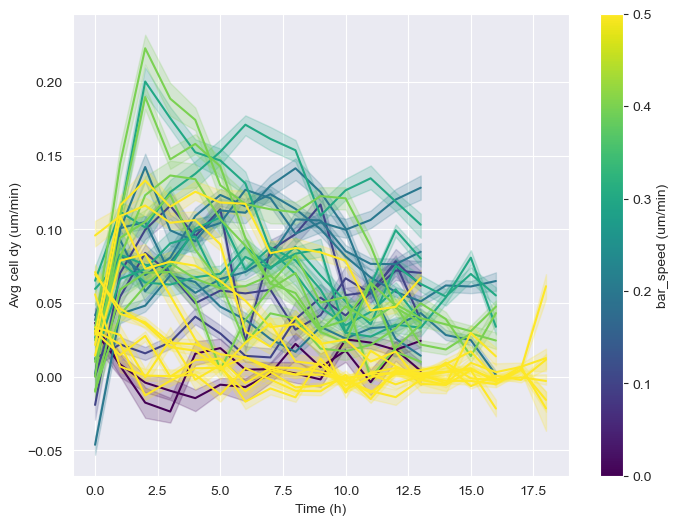

In [29]:
import matplotlib as mpl


fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# ax.set_ylim(0, 0.5)

experiments = {
    "bar_speed": [],
    "avg_speed": [],
    "median_speed": [],
    "top_speed": [],
    "n_cells": [],
    "avg_speed_any": [],
}

pal = plt.get_cmap("viridis")

for src in list(track_path.iterdir()):
    if not src.name.endswith(".csv"):
        continue

    if src.stem[:3] != "bar":
        continue

    spots_df = pd.read_csv(src)


    spots_df["id"] = spots_df.index
    spots_df["parent"] = spots_df.groupby("track_id").shift(1)["id"]
    spots_df["parent"] = spots_df["parent"].fillna(-1).astype(int)
    spots_df["um_x"] = spots_df["px_x"] * 0.66
    spots_df["um_y"] = spots_df["px_y"] * 0.66
    spots_df["t"] = spots_df["frame"] * 5
    spots_df["t_hour"] = spots_df["t"] // 60
    spots_df["dif_frame"] = spots_df["frame"] - spots_df.groupby("track_id").shift(1)["frame"]

    barstr = src.stem.split(".")[0][3:]

    bar_speed = int(barstr) / (10**(len(barstr) - 1))
    print(bar_speed)
    # period = 100
    # period_time = period / bar_speed
    # duty_cycle = 0.2
    #
    # spots_df["phase"] = ((spots_df["t"] - (spots_df["um_y"] / bar_speed)) % period_time) / period_time
    # spots_df["phase_coarse"] = (spots_df["phase"] // 0.1) * 0.1

    for col in ["px_x", "px_y", "um_x", "um_y"]:
        spots_df[f"parent_{col}"] = spots_df.groupby("track_id").shift(1)[col]
        spots_df[f"dif_{col}"] = (spots_df[col] - spots_df[f"parent_{col}"]) / spots_df["dif_frame"]
        spots_df[f"{col}_per_min"] = spots_df[f"dif_{col}"] / 5

    spots_df["um_speed"] = np.sqrt(spots_df["um_x_per_min"] ** 2 + spots_df["um_y_per_min"] ** 2)

    # spots_df["dif_px_x"] = spots_df["dif_px_x"] / spots_df["dif_frame"]

    subset = spots_df[
        (spots_df["um_x"] > spots_df["um_x"].quantile(0.25)) &
        (spots_df["um_x"] < spots_df["um_x"].quantile(0.75)) &
        (spots_df["um_y"] > spots_df["um_y"].quantile(0.25)) &
        (spots_df["um_y"] < spots_df["um_y"].quantile(0.5))
    ].copy()

    sns.lineplot(data=subset, x="t_hour", y="um_y_per_min", errorbar=("ci", 95), color=pal(bar_speed*2), label=f"{bar_speed: 0.2f} um/min",
                 estimator="median", ax=ax, legend=False)

    experiments["bar_speed"].append(bar_speed)
    experiments["avg_speed"].append(subset[subset["t_hour"].between(3, 7)]["um_y_per_min"].mean())
    experiments["median_speed"].append(subset[subset["t_hour"].between(3, 7)]["um_y_per_min"].median())
    experiments["top_speed"].append(subset[subset["t_hour"].between(3, 7)]["um_y_per_min"].quantile(0.9))
    experiments["n_cells"].append(subset[subset["t_hour"].between(3, 7)].groupby("frame")["um_x"].count().mean())
    experiments["avg_speed_any"].append(subset[subset["t_hour"].between(3, 7)]["um_speed"].mean())

cmap = plt.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=0, vmax=0.5)

# Create the ScalarMappable and add the colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("bar_speed (um/min)")
ax.set_ylabel("Avg cell dy (um/min)")
ax.set_xlabel("Time (h)")

# ax = plt.gca()
# handles, labels = ax.get_legend_handles_labels()
# new_labels = [label[:3] for label in labels]
# ax.legend(handles, new_labels, title = 'Phase')

plt.show()

# sns.histplot(data=spots_df, x="um_speed", bins=100)
# plt.show()
# spots_df

Index(['bar_speed', 'avg_speed', 'median_speed', 'top_speed', 'n_cells',
       'avg_speed_any', 'bar_speed_h', 'avg_speed_h', 'any_speed_h'],
      dtype='object')


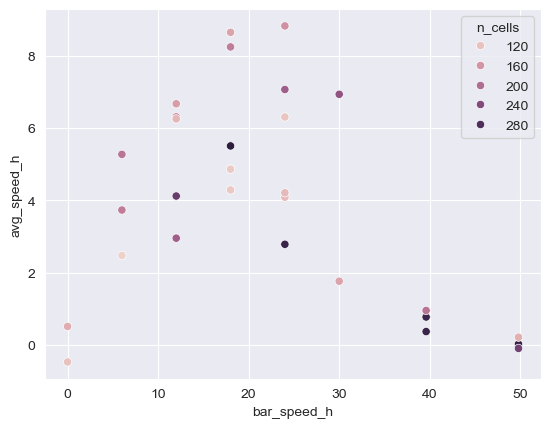

In [28]:
experiments_df = pd.DataFrame(experiments)
experiments_df["bar_speed_h"] = experiments_df["bar_speed"] * 60
experiments_df["avg_speed_h"] = experiments_df["avg_speed"] * 60
experiments_df["any_speed_h"] = experiments_df["avg_speed_any"] * 60

print(experiments_df.columns)

sns.scatterplot(data=experiments_df, x="bar_speed_h", y="avg_speed_h", hue="n_cells")
plt.show()

477it [00:01, 459.43it/s]


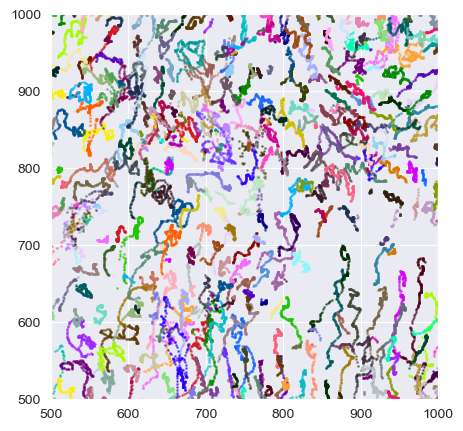

In [10]:

pal = glasbey.create_palette(100)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_xlim(500, 1000)
ax.set_ylim(500, 1000)

subset = spots_df[spots_df["px_x"].between(500, 1000) & spots_df["px_y"].between(500, 1000)].copy()

for i, track_id in tqdm(enumerate(subset["track_id"].unique())):
    x, y = subset[subset["track_id"] == track_id][["px_x", "px_y"]].values.T

    ax.scatter(x, y, s=1, color=pal[i % 100], alpha=0.5)

plt.show()

In [4]:
# edge_map = {child: parent for parent, child in graph.edges()}
spots_df["parent"] = spots_df.index.map(edge_map)
spots_df["x"] = spots_df["POSITION_X"] * 0.66
spots_df["y"] = spots_df["POSITION_Y"] * 0.66
spots_df["t"] = spots_df["FRAME"] * 5
parents = edge_map.values()

X = spots_df.loc[parents, ["t", "x", "y"]]

spots_df["parent_t"] = spots_df["parent"].map(X["t"])
spots_df["parent_x"] = spots_df["parent"].map(X["x"])
spots_df["parent_y"] = spots_df["parent"].map(X["y"])

spots_df["dx"] = (spots_df["x"] - spots_df["parent_x"]) / (spots_df["t"] - spots_df["parent_t"])
spots_df["dy"] = (spots_df["y"] - spots_df["parent_y"]) / (spots_df["t"] - spots_df["parent_t"])

bar_speed = 1.0
period = 100
period_time = period / bar_speed
duty_cycle = 0.2

spots_df["phase"] = ((spots_df["t"] - (spots_df["y"] / bar_speed)) % period_time) / period_time



In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

subset = spots_df[
    (spots_df["x"] > spots_df["x"].quantile(0.25)) &
    (spots_df["x"] < spots_df["x"].quantile(0.75)) &
    (spots_df["y"] > spots_df["y"].quantile(0.25)) &
    (spots_df["y"] < spots_df["y"].quantile(0.75))
].copy()

subset["hour"] = subset["t"] // 60
subset["phase_group"] = subset["phase"] // 0.05

sns.lineplot(data=subset, x="hour", y="dy", hue="phase_group", palette="tab10")
plt.show()

KeyError: 'x'

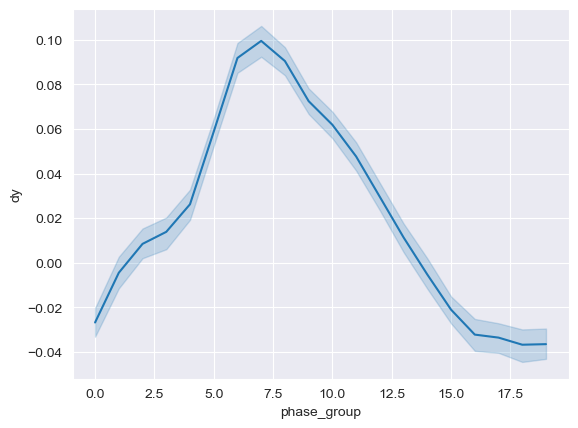

In [6]:
sns.lineplot(data=subset, x="phase_group", y="dy", )
plt.show()

In [4]:
def process_trackmate_tree(tree: ET) -> (pd.DataFrame, DiGraph):
    """
    Process trackmate tree
    :param tree: ElementTree object from trackmate xml file
    :return:
    """

    graph = DiGraph()
    root = tree.getroot()

    # iterate through spot elements and collect attributes
    spots = root.find("Model").find("AllSpots")
    spots_collect = []

    for spot_frame in tqdm(spots, desc="parsing spots; frame"):
        for spot in spot_frame:
            # spot id is always an int
            spot_id = int(spot.get("ID"))
            graph.add_node(spot_id)

            # get all attributes and convert to floats
            spot_attributes = spot.attrib
            spot_attributes = {key: float(value) for key, value in spot_attributes.items() if key != "name"}

            spot_attributes["graph_key"] = spot_id
            spot_attributes["FRAME"] = int(spot_attributes["FRAME"])

            # mostly used in 2d
            if spot.text:
                spot_attributes["roi"] = [float(pt) for pt in spot.text.split(" ")]

            spots_collect.append(spot_attributes)

    # use graph key universally as an index
    spots_df = pd.DataFrame(spots_collect, index=[c["graph_key"] for c in spots_collect])
    assert np.all(spots_df.index == spots_df["ID"])

    # iterate through track elements to construct graph and assign trackid
    tracks = root.find("Model").find("AllTracks")

    for i, track in enumerate(tqdm(tracks, desc="parsing edges; track"), start=1):
        track_id = i

        this_track_spots = set()

        for edge in track:
            edge_attributes = edge.attrib

            source_spot_id = int(edge_attributes["SPOT_SOURCE_ID"])
            target_spot_id = int(edge_attributes["SPOT_TARGET_ID"])

            this_track_spots.add(source_spot_id)
            this_track_spots.add(target_spot_id)

        this_track_spots = list(this_track_spots)

        track_spots = spots_df.loc[this_track_spots].sort_values(by=["FRAME"]).index
        for source, target in zip(track_spots[:-1], track_spots[1:]):
            source_spot_frame = int(spots_df.loc[source]["FRAME"])
            target_spot_frame = int(spots_df.loc[target]["FRAME"])

            # add edge to graph
            graph.add_edge(source, target, track_id=track_id, time=target_spot_frame - source_spot_frame)

        spots_df.loc[this_track_spots, "linear_track_id"] = track_id

    print(f"track id 0 corresponds to {np.sum(spots_df['linear_track_id'].isna())} edgeless spots")

    return spots_df, graph


# tree = ET.parse(r"D:\FeedbackControl\data\results\bar05.07_tracks.xml")
#
# spots_df, graph = process_trackmate_tree(tree)

In [5]:
sources = {
    "0.5": r"D:\FeedbackControl\data\results\bar05.07_tracks.xml",
    "1.0": r"D:\FeedbackControl\data\results\bar1.00_cpmasks.xml",
}

dfs = {}

for speed, source in sources.items():
    tree = ET.parse(source)
    spots_df, graph = process_trackmate_tree(tree)
    edge_map = {child: parent for parent, child in graph.edges()}
    spots_df["parent"] = spots_df.index.map(edge_map)
    spots_df["x"] = spots_df["POSITION_X"] * 0.66
    spots_df["y"] = spots_df["POSITION_Y"] * 0.66
    spots_df["t"] = spots_df["FRAME"] * 5
    parents = edge_map.values()

    X = spots_df.loc[parents, ["t", "x", "y"]]

    spots_df["parent_t"] = spots_df["parent"].map(X["t"])
    spots_df["parent_x"] = spots_df["parent"].map(X["x"])
    spots_df["parent_y"] = spots_df["parent"].map(X["y"])

    spots_df["dx"] = (spots_df["x"] - spots_df["parent_x"]) / (spots_df["t"] - spots_df["parent_t"])
    spots_df["dy"] = (spots_df["y"] - spots_df["parent_y"]) / (spots_df["t"] - spots_df["parent_t"])

    bar_speed = float(speed)
    period = 100
    period_time = period / bar_speed
    duty_cycle = 0.2

    spots_df["phase"] = ((spots_df["t"] - (spots_df["y"] / bar_speed)) % period_time) / period_time

    dfs[speed] = spots_df




parsing edges; track: 100%|██████████| 4132/4132 [00:35<00:00, 115.58it/s]


track id 0 corresponds to 1576 edgeless spots


parsing edges; track: 100%|██████████| 4114/4114 [00:38<00:00, 106.64it/s]


track id 0 corresponds to 1422 edgeless spots


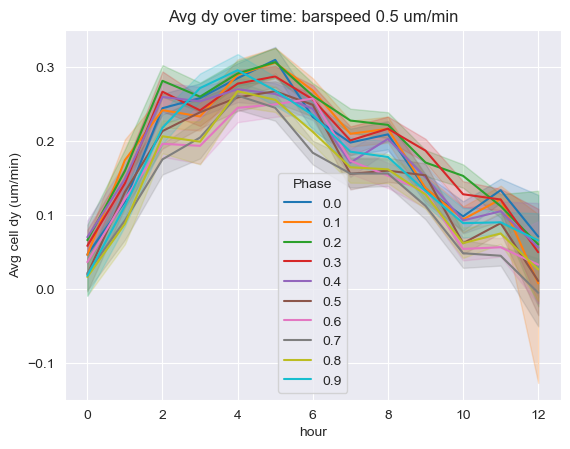

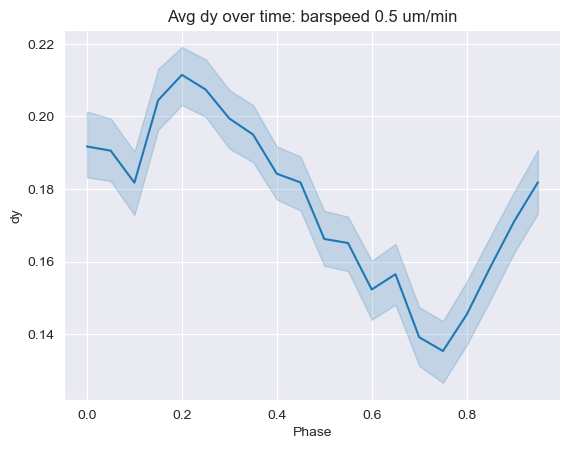

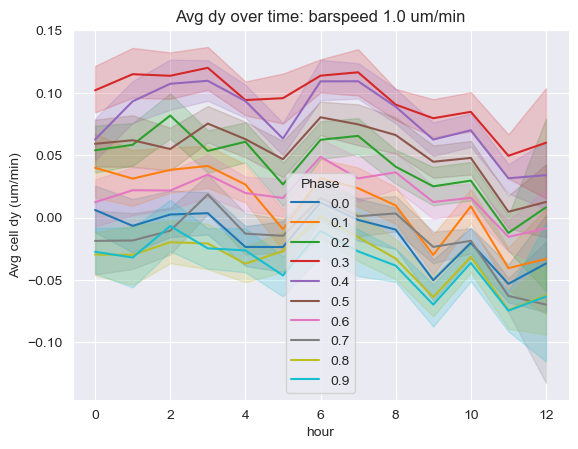

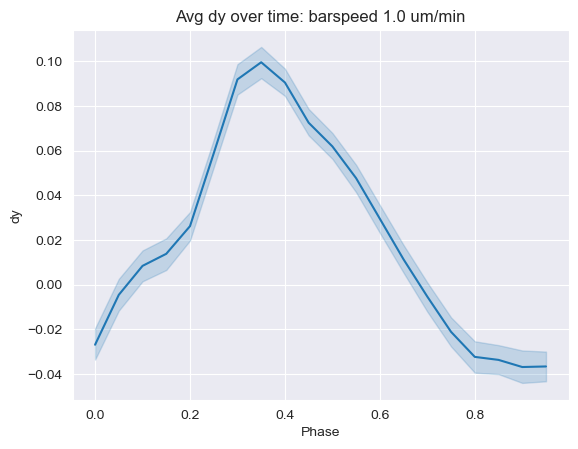

In [6]:
for speed, spots_df in dfs.items():

    subset = spots_df[
        (spots_df["x"] > spots_df["x"].quantile(0.25)) &
        (spots_df["x"] < spots_df["x"].quantile(0.75)) &
        (spots_df["y"] > spots_df["y"].quantile(0.25)) &
        (spots_df["y"] < spots_df["y"].quantile(0.75))
        ].copy()

    subset["hour"] = subset["t"] // 60
    subset["phase_group_fine"] = (subset["phase"] // 0.05) * 0.05
    subset["phase_group_broad"] = (subset["phase"] // 0.1) * 0.1

    sns.lineplot(data=subset, x="hour", y="dy", hue="phase_group_broad", palette="tab10")
    plt.title(f"Avg dy over time: barspeed {speed} um/min")

    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [label[:3] for label in labels]
    ax.legend(handles, new_labels, title = 'Phase')

    plt.ylabel("Avg cell dy (um/min)")
    plt.show()

    sns.lineplot(data=subset, x="phase_group_fine", y="dy", )
    plt.title(f"Avg dy over time: barspeed {speed} um/min")
    plt.xlabel("Phase")
    plt.show()

In [9]:
import napari

cmap = plt.get_cmap("PiYG")

viewer = napari.Viewer()

df = dfs["1.0"]

df = df[~df["dy"].isna()]

X = df[["FRAME", "x", "y"]].values
y = df["dy"].values

cmax = max(np.abs(np.quantile(y, 0.99)), np.abs(np.quantile(y, 0.01)))
cmin = -cmax

print(cmax)

color = cmap(np.clip(y, cmin, cmax) - cmin / (cmax - cmin))

scatter = viewer.add_points(X, size=25, face_color=color, name="dy", border_color="black")

napari.run()

0.46156648605629186


In [ ]:
color

# bounce

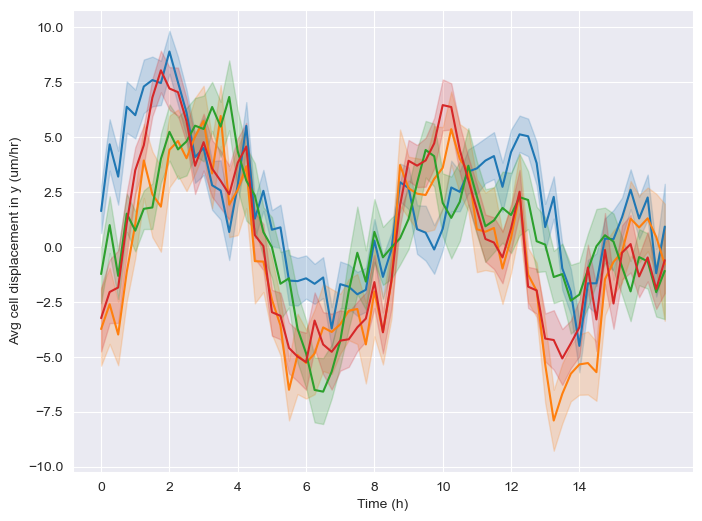

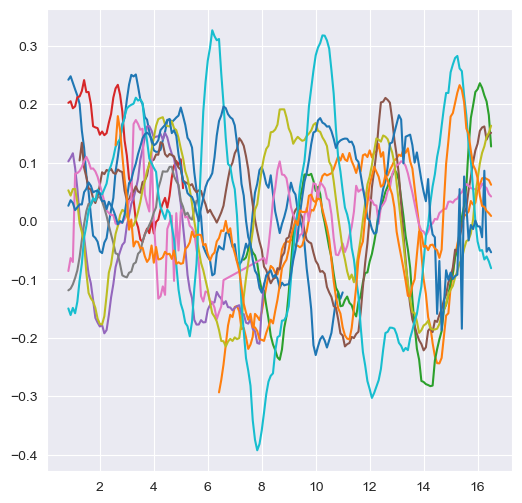